# Join parquet Files

Import Libraries

In [51]:
import pyarrow.parquet as pq
import os
import pandas as pd
from pathlib import Path
import re
from datetime import datetime, timezone
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 

Concate Parquets

In [3]:
have_df = True

In [4]:
def concate_parquet(directory_path):

    # Get a list of Parquet files in the directory
    parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

    # Initialize an empty list to store DataFrames
    dfs = []

    # Iterate through each Parquet file
    for file in parquet_files:
        # Read the Parquet file into a DataFrame
        df = pq.read_table(file).to_pandas()
        
        # Extract the substring before the underscore from the filename
        filename = os.path.basename(file)
        appid = filename.split('_')[0]
        
        # Add a new column with the extracted prefix value
        df['AppId'] = appid
        
        # Append the modified DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into one
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df


In [5]:
if not have_df:
    parquets_df = concate_parquet('./data/parquets/')
    parquets_df

Column author contains a dictionary

Transform the dictionary into columns of the dataframe

In [6]:
def expand_column(concatenated_df):
    # Use json_normalize to expand the dictionary column into separate columns
    expanded_df = pd.json_normalize(concatenated_df['author'])

    # Concatenate the expanded DataFrame with the original DataFrame
    result_df = pd.concat([concatenated_df, expanded_df], axis=1)

    # Drop the original dictionary column
    result_df.drop('author', axis=1, inplace=True)

    return result_df

In [7]:
if not have_df:
    parquets_df = expand_column(parquets_df)
    parquets_df

Save dataframe

In [8]:
if not have_df:
    parquets_df['recommendationid'].duplicated().sum() # Cant be index

In [9]:
if not have_df:
    parquets_df.to_csv('parquets_df.csv', index=False)

In [30]:
if have_df:
    parquets_df = pd.read_csv("parquets_df.csv")
    parquets_df

C:\Users\abdar\AppData\Local\Temp\ipykernel_30392\1053520584.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  parquets_df = pd.read_csv("parquets_df.csv")


## EDA

Information about the Data

In [11]:
# Display the basic information about the DataFrame
print("DataFrame Info:")
print(parquets_df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509518 entries, 0 to 1509517
Data columns (total 25 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   recommendationid             1509518 non-null  int64  
 1   language                     1509518 non-null  object 
 2   review                       1506197 non-null  object 
 3   timestamp_created            1509518 non-null  int64  
 4   timestamp_updated            1509518 non-null  int64  
 5   voted_up                     1509518 non-null  bool   
 6   votes_up                     1509518 non-null  int64  
 7   votes_funny                  1509518 non-null  int64  
 8   weighted_vote_score          1509518 non-null  float64
 9   comment_count                1509518 non-null  int64  
 10  steam_purchase               1509518 non-null  bool   
 11  received_for_free            1509518 non-null  bool   
 12  written_during_early_acces

Check for Missing Values

In [12]:
# Check for missing values
print("\nMissing Values:")
print(parquets_df.isnull().sum())


Missing Values:
recommendationid                     0
language                             0
review                            3321
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
hidden_in_steam_china                0
steam_china_location           1509518
AppId                                0
timestamp_dev_responded        1507673
developer_response             1507673
steamid                              0
num_games_owned                      0
num_reviews                          0
playtime_forever                     0
playtime_last_two_weeks              0
playtime_at_review                2124
last_played                          0
dtype: i

Check for duplicates

In [13]:
parquets_df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1509513    False
1509514    False
1509515    False
1509516    False
1509517    False
Length: 1509518, dtype: bool

Datatype changes

In [14]:
def preprocess_review(review):
    if isinstance(review, str):
        # Remove non-European characters
        review = re.sub(r'[^\x00-\x7F]', '', review)
        # Remove newline and carriage return characters
        review = review.replace('\n', '').replace('\r', '')
    return review

def preprocess_gamereviews(gamereviews):
    # Handle missing values in the review column
    gamereviews["review"] = gamereviews["review"].fillna("")
    
    # Preprocess the review
    gamereviews["review"] = gamereviews["review"].apply(lambda x: preprocess_review(x))
    
    # Skip rows with reviews less than 20 characters
    gamereviews = gamereviews[gamereviews["review"].apply(len) >= 20].copy()
    
    # Format "timestamp_created" to int
    gamereviews["timestamp_created"] = gamereviews["timestamp_created"].astype('int64')
    
    # Format timestamps
    gamereviews["timestamp_created"] = pd.to_datetime(gamereviews["timestamp_created"], unit='s', utc=True)
    gamereviews["timestamp_updated"] = pd.to_datetime(gamereviews["timestamp_updated"], unit='s', utc=True)
    gamereviews["last_played"] = pd.to_datetime(gamereviews["last_played"], unit='s', utc=True)
    
    # Remove unnecessary fields
    gamereviews.drop(columns=["language", "hidden_in_steam_china", "steam_china_location"], inplace=True)
    
    # Format boolean fields
    gamereviews["voted_up"] = gamereviews["voted_up"].astype(bool)
    gamereviews["steam_purchase"] = gamereviews["steam_purchase"].astype(bool)
    gamereviews["received_for_free"] = gamereviews["received_for_free"].astype(bool)
    gamereviews["written_during_early_access"] = gamereviews["written_during_early_access"].astype(bool)
    gamereviews["weighted_vote_score"] = gamereviews["weighted_vote_score"].astype(float)
    
    return gamereviews

In [33]:
parquets_df = preprocess_gamereviews(parquets_df)
parquets_df

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,...,AppId,timestamp_dev_responded,developer_response,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
0,164992248,"Got this when it's 76% off, it was a good off....",2024-05-09 14:10:00+00:00,2024-05-09 14:10:00+00:00,True,0,0,0.000000,0,True,...,1000760,NaN,NaN,76561198339039799,812,354,544,0,544.0,2023-07-25 10:34:08+00:00
2,164003442,"I really wanted to like this game, I really di...",2024-05-01 17:23:26+00:00,2024-05-01 17:23:26+00:00,False,1,0,0.522613,0,True,...,1000760,NaN,NaN,76561198000964997,635,3,315,109,315.0,2024-05-01 17:06:42+00:00
3,162085671,Fun pretty linear action game. combat is prett...,2024-04-03 04:16:12+00:00,2024-04-03 04:16:12+00:00,True,0,0,0.000000,0,True,...,1000760,NaN,NaN,76561198034437023,301,47,355,0,355.0,2024-03-29 19:25:50+00:00
4,162067131,Indonesia:Desain peta yang tidak biasa.Kemampu...,2024-04-02 22:16:11+00:00,2024-04-02 22:16:11+00:00,True,0,0,0.000000,0,True,...,1000760,NaN,NaN,76561199466323974,24,7,1522,0,1522.0,2024-03-28 12:21:48+00:00
5,161905365,"For 5$ CAD this is a no brainer, an excellent ...",2024-03-31 19:53:22+00:00,2024-03-31 19:53:22+00:00,True,0,0,0.000000,0,True,...,1000760,NaN,NaN,76561198020772325,0,51,1099,0,209.0,2024-04-14 15:18:14+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509512,48268398,EDIT: My original review (below) failed to tak...,2019-01-12 04:53:56+00:00,2019-01-13 05:16:46+00:00,True,2,0,0.000000,0,True,...,994220,NaN,NaN,76561197982684927,0,1,376,0,376.0,2019-01-17 05:34:30+00:00
1509513,48266255,This game will likely draw a lot of comparison...,2019-01-12 02:40:48+00:00,2019-01-12 02:40:48+00:00,True,13,0,0.544656,0,True,...,994220,NaN,NaN,76561198001876420,1436,478,368,0,284.0,2019-02-03 16:01:53+00:00
1509514,48257776,Developer responded quickly to complains about...,2019-01-11 18:46:17+00:00,2019-01-16 05:04:57+00:00,True,6,0,0.513300,1,True,...,994220,NaN,NaN,76561198059126249,0,162,715,0,424.0,2020-08-19 14:14:02+00:00
1509515,48255767,Great game for Early Access. Very nice and pol...,2019-01-11 16:49:59+00:00,2019-01-11 16:49:59+00:00,True,3,1,0.476565,0,True,...,994220,NaN,NaN,76561198085196288,36,14,4794,0,156.0,2022-09-15 18:42:56+00:00


## Numerical Variables

In [16]:
# Select numerical variables
# Remove Id variables
numerical_df = parquets_df.select_dtypes(include=['int64', 'float64']).drop(['recommendationid', 'AppId', 'steamid'],axis=1)

Summary Statistics

In [18]:
# Get to know the dataset
numerical_df.describe().T

,count,mean,std,min,25%,50%,75%,max
votes_up,1138111.0,2.534989e+00,6.800788e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.396300e+04
votes_funny,1138111.0,5.283344e+04,1.506361e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.294967e+09
weighted_vote_score,1138111.0,1.806784e-01,2.500015e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.938272e-01,9.869002e-01
comment_count,1138111.0,1.193978e-01,2.943425e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.802000e+03
timestamp_dev_responded,1730.0,1.630984e+09,6.035342e+07,1.434561e+09,1.582601e+09,1.651863e+09,1.681910e+09,1.715266e+09
num_games_owned,1138111.0,1.441460e+02,4.487972e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.360000e+02,3.089500e+04
num_reviews,1138111.0,2.513901e+01,1.247641e+02,1.000000e+00,3.000000e+00,7.000000e+00,2.000000e+01,1.148500e+04
playtime_forever,1138111.0,7.713476e+03,2.508819e+04,0.000000e+00,5.880000e+02,2.953000e+03,7.825000e+03,4.201472e+06
playtime_last_two_weeks,1138111.0,1.964227e+02,6.337672e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,2.011700e+04
playtime_at_review,1136235.0,4.376035e+03,1.369875e+04,1.000000e+00,3.170000e+02,1.471000e+03,4.707000e+03,2.554031e+06


Correlation Matrix

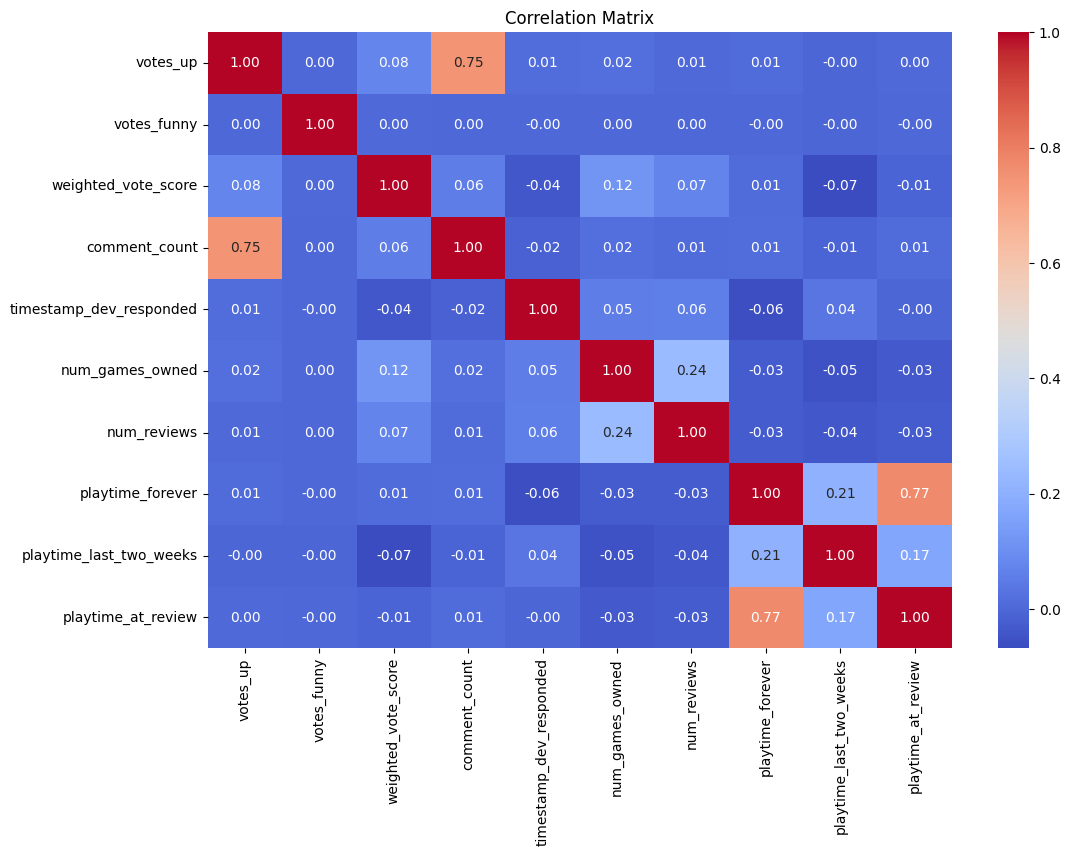

In [17]:
# Calculate correlations between numerical columns
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


User's Data

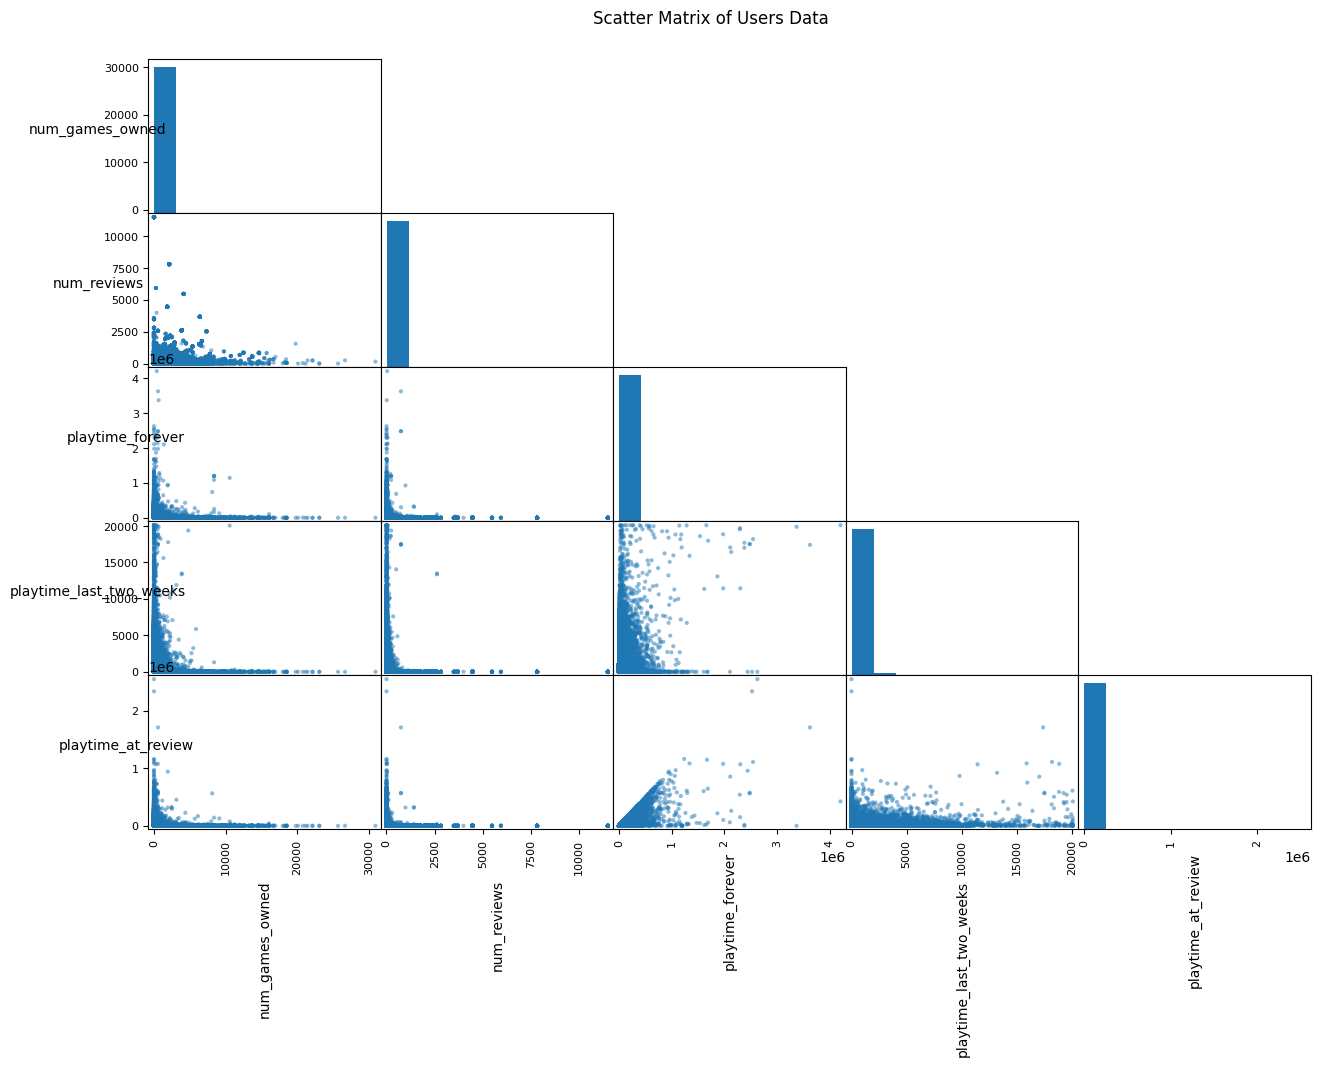

In [55]:
# Create a scatter matrix
scattermatrix = scatter_matrix(parquets_df[['num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review']],
                                diagonal='hist', figsize=(15,10))

# Get the number of columns in the matrix
n = scattermatrix.shape[1]

# Mask the upper triangle of the matrix
for i in range(n):
    for j in range(i + 1, n):
        scattermatrix[i, j].set_visible(False)
        
# Rotate the axis labels
for ax in scattermatrix.ravel():    
    ax.yaxis.label.set_rotation(0)
    ax.xaxis.label.set_rotation(90)

# Choose a title and make the title appear closer to the graph
plt.suptitle("Scatter Matrix of Users Data", y = 0.93)
    
# Show the plot
plt.show()

Review's Data

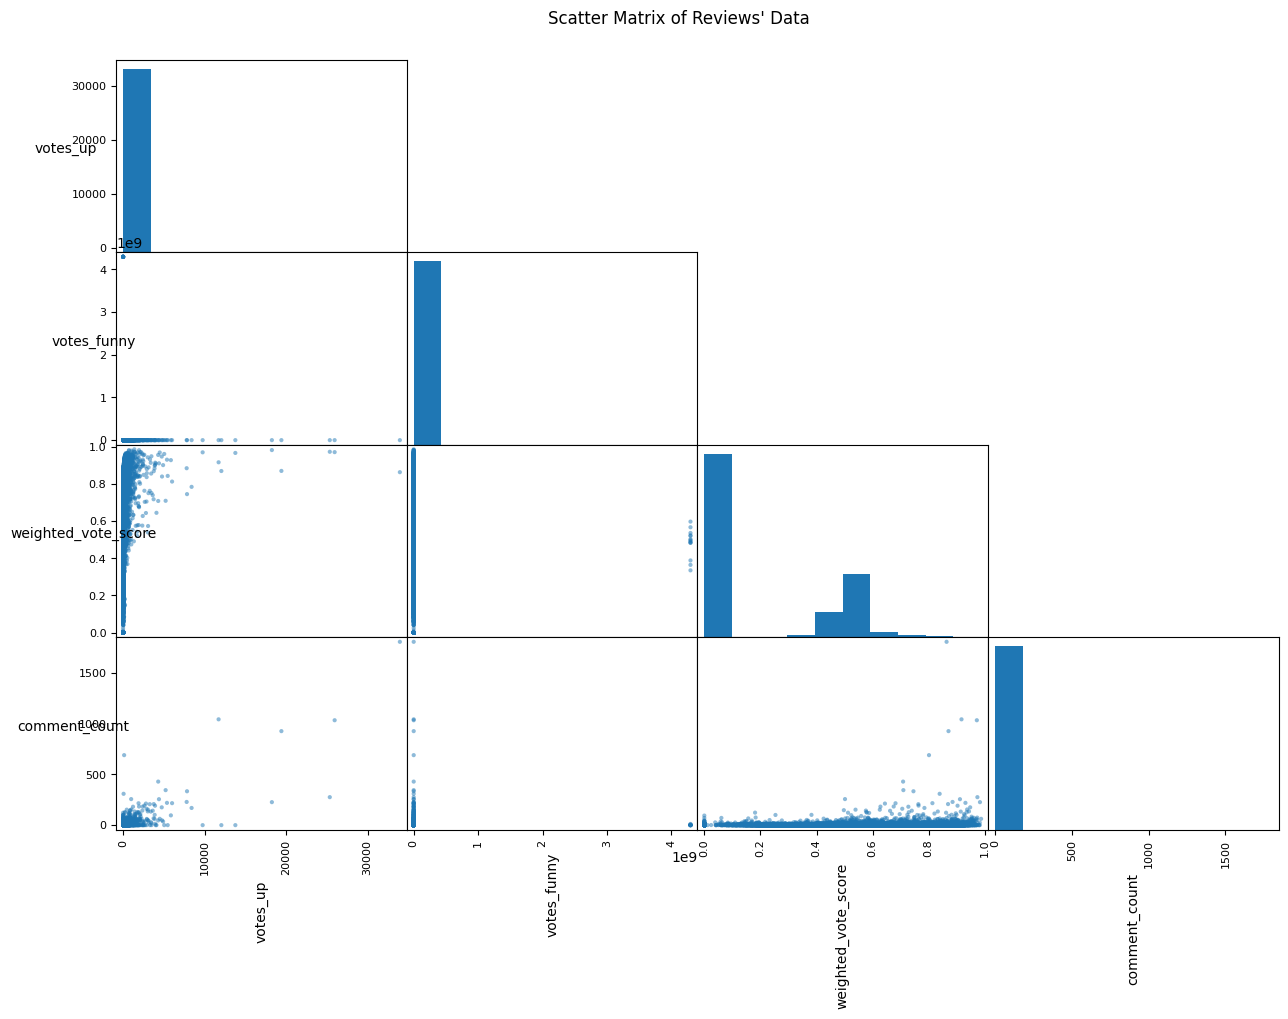

In [56]:
# Create a scatter matrix
scattermatrix = scatter_matrix(parquets_df[['votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count']],
                                diagonal='hist', figsize=(15,10))

# Get the number of columns in the matrix
n = scattermatrix.shape[1]

# Mask the upper triangle of the matrix
for i in range(n):
    for j in range(i + 1, n):
        scattermatrix[i, j].set_visible(False)
        
# Rotate the axis labels
for ax in scattermatrix.ravel():    
    ax.yaxis.label.set_rotation(0)
    ax.xaxis.label.set_rotation(90)

# Choose a title and make the title appear closer to the graph
plt.suptitle("Scatter Matrix of Reviews' Data", y = 0.93)
    
# Show the plot
plt.show()

## Time-Based Variables

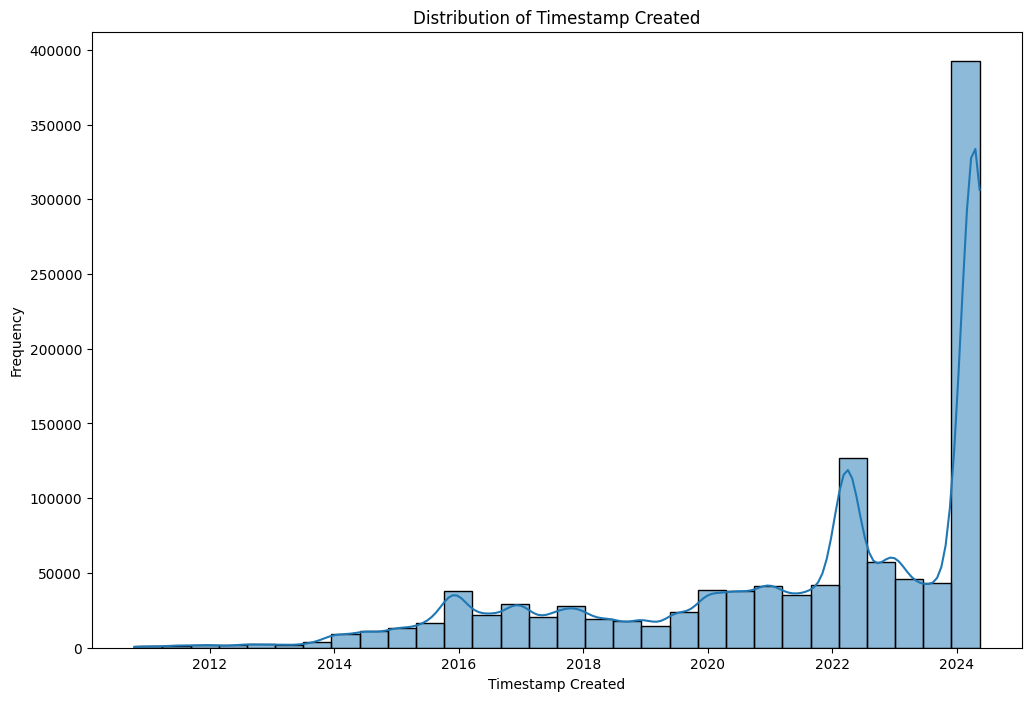

In [22]:
# Distribution of timestamp_created
plt.figure(figsize=(12, 8))
sns.histplot(data=parquets_df['timestamp_created'], bins=30, kde=True)
plt.title("Distribution of Timestamp Created")
plt.xlabel("Timestamp Created")
plt.ylabel("Frequency")
plt.show()

C:\Users\abdar\AppData\Local\Temp\ipykernel_30392\3617703486.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  parquets_df['voted_up'].resample('M').count().plot()


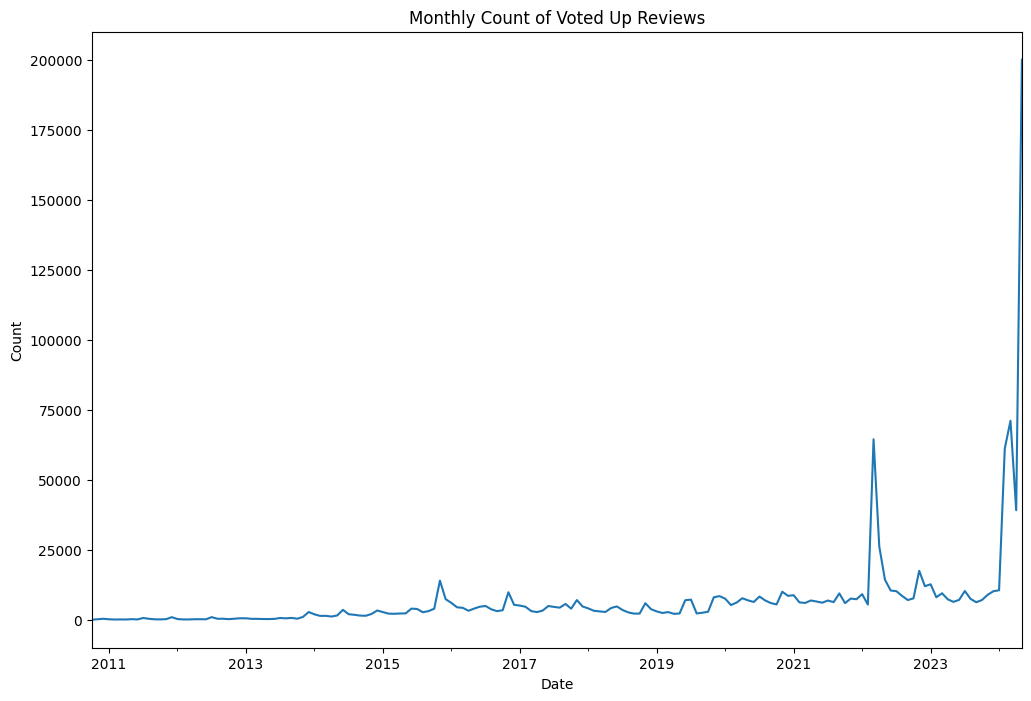

In [23]:
# Time series analysis
parquets_df.set_index('timestamp_created', inplace=True)
plt.figure(figsize=(12, 8))
parquets_df['voted_up'].resample('M').count().plot()
plt.title("Monthly Count of Voted Up Reviews")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

# Reviews Variable

In [82]:
# Filter reviews that start with "EDIT:"
edit_reviews = parquets_df[parquets_df['review'].str.startswith('EDIT:')]
print(len(edit_reviews))

1008


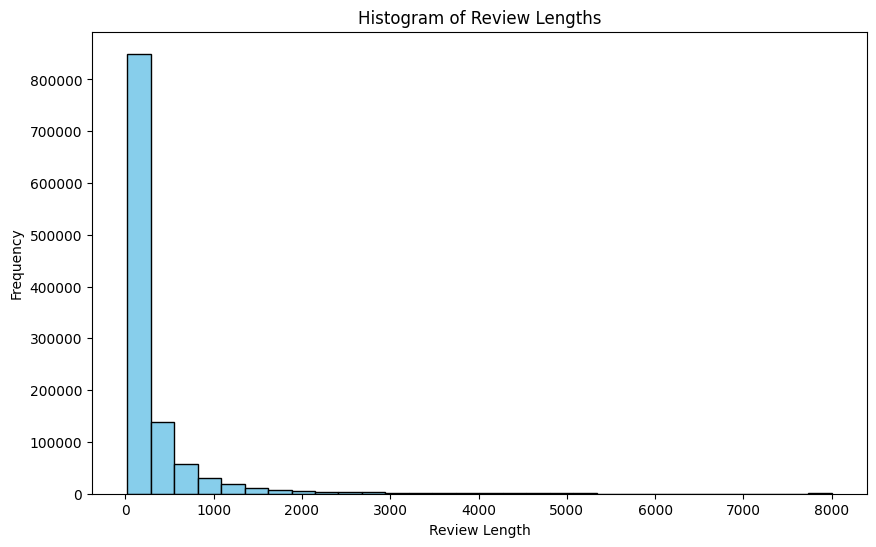

In [71]:
# Histogram of Review Lengths
parquets_df['review_length'] = parquets_df['review'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(parquets_df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [27]:
from wordcloud import WordCloud

# Generate word cloud for reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(parquets_df['review'].dropna()))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Reviews")
plt.axis('off')
plt.show()


KeyboardInterrupt: 

# Other Visualizations

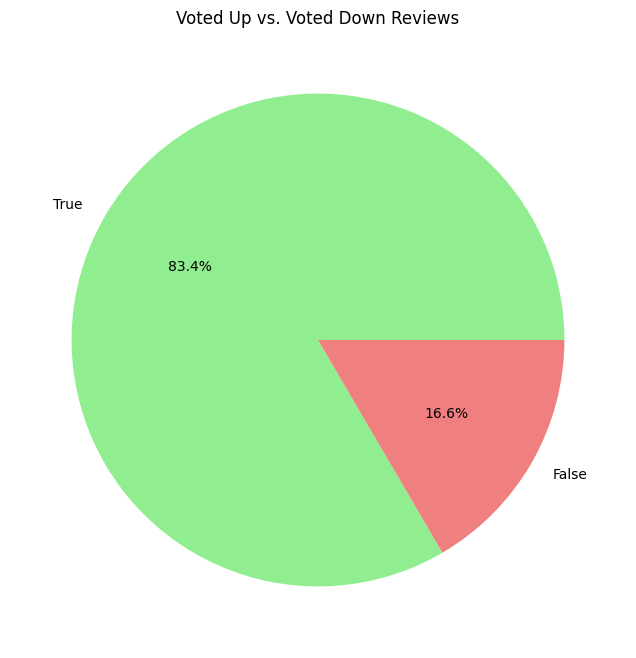

In [73]:
# Pie Chart of Voted Up vs. Voted Down Reviews
voted_counts = parquets_df['voted_up'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(voted_counts, labels=voted_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Voted Up vs. Voted Down Reviews')
plt.show()

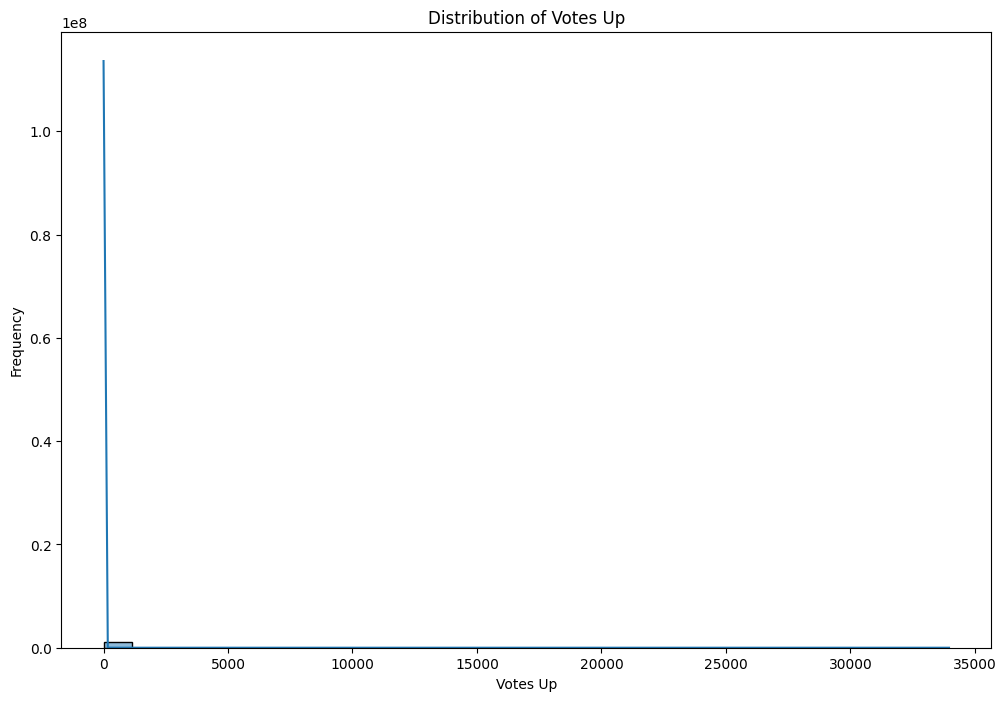

In [145]:
# Check distribution of numerical variables
plt.figure(figsize=(12, 8))
sns.histplot(data=parquets_df['votes_up'], bins=30, kde=True)
plt.title("Distribution of Votes Up")
plt.xlabel("Votes Up")
plt.ylabel("Frequency")
plt.show()

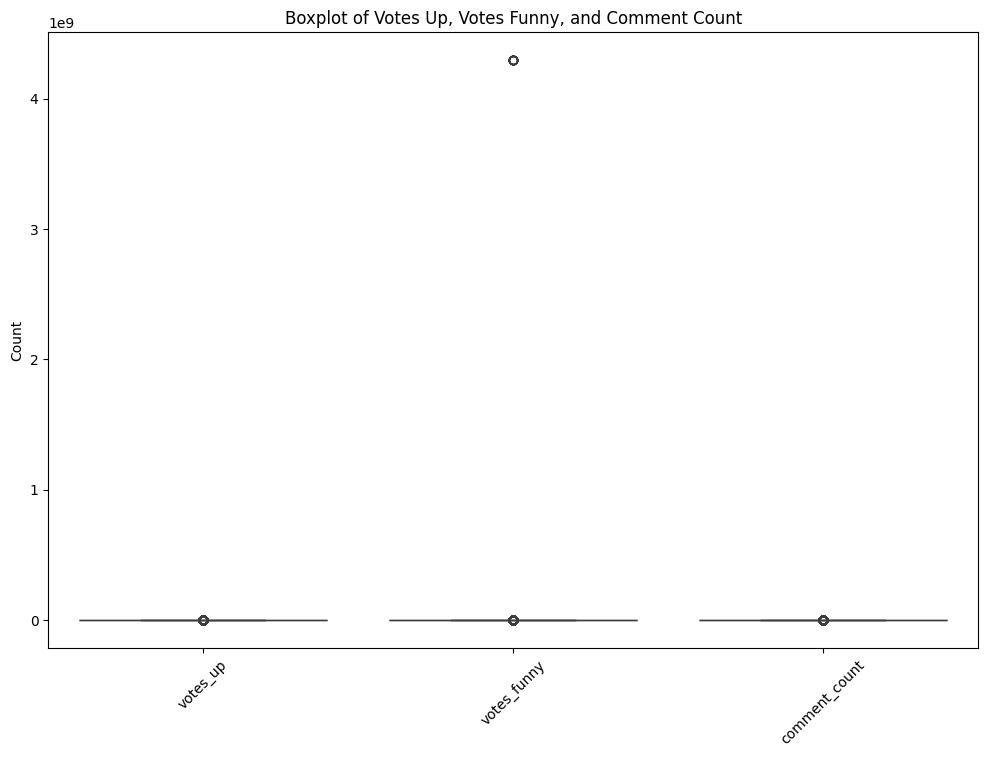

In [ ]:
# Boxplot for numerical columns
plt.figure(figsize=(12, 8))
sns.boxplot(data=parquets_df[['votes_up', 'votes_funny', 'comment_count']]) # As outlier, can be explored.
plt.title("Boxplot of Votes Up, Votes Funny, and Comment Count")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [146]:
# Pairplot for numerical columns
sns.pairplot(parquets_df[['votes_up', 'votes_funny', 'comment_count']])
plt.suptitle("Pairplot of Votes Up, Votes Funny, and Comment Count")
plt.show()

KeyboardInterrupt: 